# Figure 5: iModulon comparisons

In [1]:
from os import path
import seaborn as sns
import matplotlib.pyplot as plt

from pymodulon.compare import compare_ica
from pymodulon.io import load_json_model
from pymodulon.plotting import *
from pymodulon.example_data import load_bsub_data, load_ecoli_data

## Set plotting style

In [2]:
sns.set_style('ticks')
plt.style.use('custom.mplstyle')

# To save plots, set save_plot=True
save_plot=False

## Load data

In [3]:
figure_dir = 'raw_figures'
data_dir = path.join('..','data','processed_data')

In [4]:
data_file = path.join(data_dir,'bsu.json.gz')
ica_data = load_json_model(data_file)
ma_data = load_bsub_data()
ecoli_data = load_ecoli_data()

# Figure SX: Dot plot

In [5]:
links, dot = compare_ica(ica_data.M,ma_data.M, show_all=False)

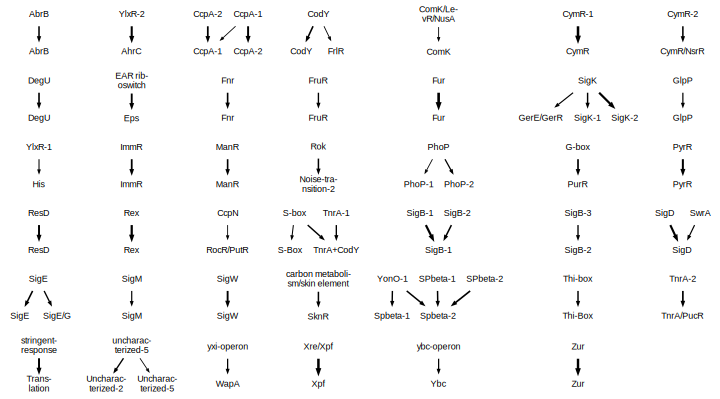

In [6]:
dot

In [7]:
dot.render(path.join('raw_figures','FigS2_bsub_compare'),format='svg',cleanup=True)

'raw_figures/FigS2_bsub_compare.svg'

# Panel A: Summary of shared iModulons

## Annotate iModulons as shared/unshared and with the category
1 = regulatory  
2 = functional  
3 = uncharacterized  

In [8]:
m1_list, m2_list, _ = list(zip(*links))
m1_list = set(m1_list)
m2_list = set(m2_list)

In [9]:
DF_M1 = pd.DataFrame([im in m1_list for im in ica_data.imodulon_names],
                     columns = ['shared'],
                      index = ica_data.imodulon_names)
DF_M1['category'] = [1 if cat == 'regulatory' else
                     2 if cat == 'functional' else
                     3 if cat == 'uncharacterized' else
                     4 for cat in ica_data.imodulon_table.category]

In [10]:
DF_M1.head()

,shared,category
S-box,True,1
uncharacterized-1,False,3
WalR,False,1
uncharacterized-2,False,3
Rex,True,1


In [11]:
ma_reg = ma_data.imodulon_table[ma_data.imodulon_table.TF.notnull()].index
ma_unc = [x for x in ma_data.imodulon_names if x.startswith('Empty') or x.startswith('Uncharacterized') or x.startswith('Noise')]

In [12]:
DF_M2 = pd.DataFrame([im in m2_list for im in ma_data.imodulon_names],
                     columns = ['shared'],
                      index = ma_data.imodulon_names)
DF_M2['category'] = [1 if im in ma_reg else 3 if im in ma_unc else 2 for im in ma_data.imodulon_names]

In [13]:
DF_M2.head()

,shared,category
PchR,False,1
FadR,False,1
CodY,True,1
AcoR,False,1
SigW,True,1


## Get counts

In [14]:
counts1 = DF_M1.reset_index().groupby(['shared','category']).count()
counts2 = DF_M2.reset_index().groupby(['shared','category']).count()

In [15]:
all_counts = pd.concat([counts1,counts2],axis=1).reset_index().fillna(0).astype(int)
all_counts.columns = ['shared','category','RNAseq','Microarray']
all_counts = all_counts.sort_values(['shared','category'],ascending=[False,True]).reset_index(drop=True)
all_counts

,shared,category,RNAseq,Microarray
0,1,1,41,45
1,1,2,5,2
2,1,3,1,3
3,0,1,11,18
4,0,2,4,1
5,0,3,5,14
6,0,4,5,0


## Draw barplot

In [16]:
sns.set_palette(sns.color_palette('dark')[:3]+sns.color_palette('pastel')[:4])

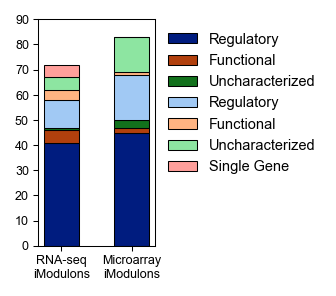

In [17]:
fig,ax = plt.subplots(figsize=(1,2))

bottoms = np.array([0,0])
labels = ['Regulatory','Functional','Uncharacterized','Regulatory','Functional','Uncharacterized','Single Gene']

for i,row in all_counts[['RNAseq','Microarray']].iterrows():
    ax.bar([0,1],row, 
           bottom = bottoms,
           width = 0.5,
           label = labels[i])
    
    bottoms += row.values
    
ax.set_ylim([0,90])
ax.set_xticklabels(['','RNA-seq\niModulons','Microarray\niModulons'])
ax.legend(bbox_to_anchor = (1,1),frameon=False)

if save_plot:
    plt.savefig(path.join('raw_figures','Fig5a_bsub_compare.pdf'))

In [28]:
41+5+1+11+4+5+5

72

In [25]:
all_counts

,shared,category,RNAseq,Microarray
0,1,1,41,45
1,1,2,5,2
2,1,3,1,3
3,0,1,11,18
4,0,2,4,1
5,0,3,5,14
6,0,4,5,0


## Panel B

In [18]:
sns.set_palette(['gray','red'])

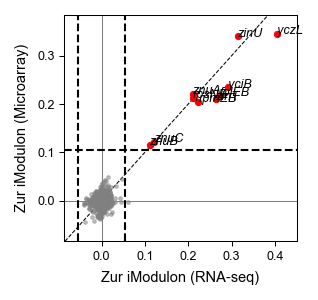

In [19]:
fig,ax = plt.subplots(figsize=(2,2))

compare_gene_weights(ica_data=ica_data, imodulon1='Zur',
                     ica_data2=ma_data, imodulon2='Zur',
                     label_font_kwargs={'fontsize':6},
                     adjust_labels=False,
                     line45=True,
                     scatter_kwargs={'alpha':0.5,'s':3},
                     ax=ax)

ax.set_xlabel('Zur iModulon (RNA-seq)')
ax.set_ylabel('Zur iModulon (Microarray)')
if save_plot:
    plt.savefig(path.join('raw_figures','Fig5b_zur.pdf'))

# Panel C

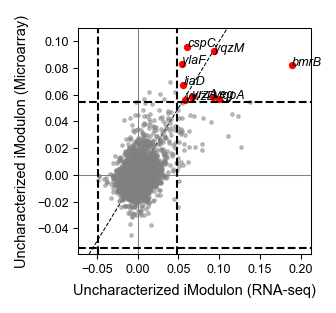

In [32]:
fig,ax = plt.subplots(figsize=(2,2))

compare_gene_weights(ica_data=ica_data, imodulon1='uncharacterized-5',
                     ica_data2=ma_data, imodulon2='Uncharacterized-2',
                     label_font_kwargs={'fontsize':6},
                     adjust_labels=False,
                     line45=True,
                     scatter_kwargs={'alpha':0.5,'s':3},
                     ax=ax)

ax.set_xlabel('Uncharacterized iModulon (RNA-seq)')
ax.set_ylabel('Uncharacterized iModulon (Microarray)')
if save_plot:
    plt.savefig(path.join('raw_figures','Fig5c_conserved_unchar.pdf'))

# Panel D: E. coli vs B. subtilis

In [44]:
links, dot = compare_ica(ica_data.M,ecoli_data.M, ortho_file = path.join('..','data','external','bsu_vs_eco_parsed.csv'),cutoff=0.3,
                         show_all=False)

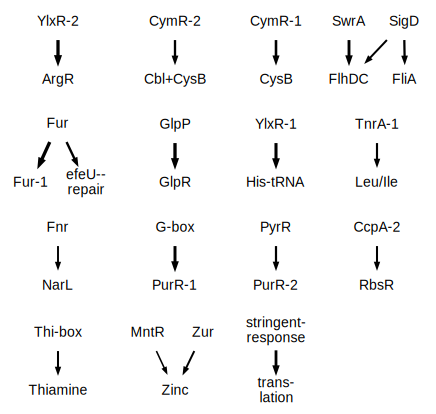

In [45]:
dot

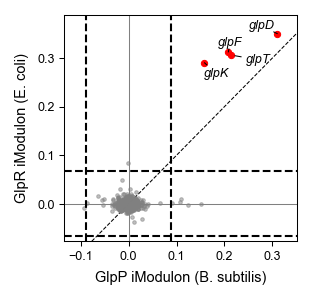

In [47]:
fig,ax = plt.subplots(figsize=(2,2))

compare_gene_weights(ica_data=ica_data, imodulon1='GlpP',
                     ica_data2=ecoli_data, imodulon2='GlpR',
                     ortho_file=path.join('..','data','external','bsu_vs_eco_parsed.csv'),
                     label_font_kwargs={'fontsize':6},
                     adjust_labels=True,
                     line45=True,
                     scatter_kwargs={'alpha':0.5,'s':3},
                     ax=ax)

ax.set_xlabel('GlpP iModulon (B. subtilis)')
ax.set_ylabel('GlpR iModulon (E. coli)')
if save_plot:
    plt.savefig(path.join('raw_figures','Fig5d_glpR.pdf'))